# Simulating Point Processes 

### Time Function 

Options 

* **Linear** - Intesity falls and rises in linear trend  
* **Constant** - Intesity is constant in the range. Sharp rises and falls 


Source: https://x-datainitiative.github.io/tick/modules/hawkes.html

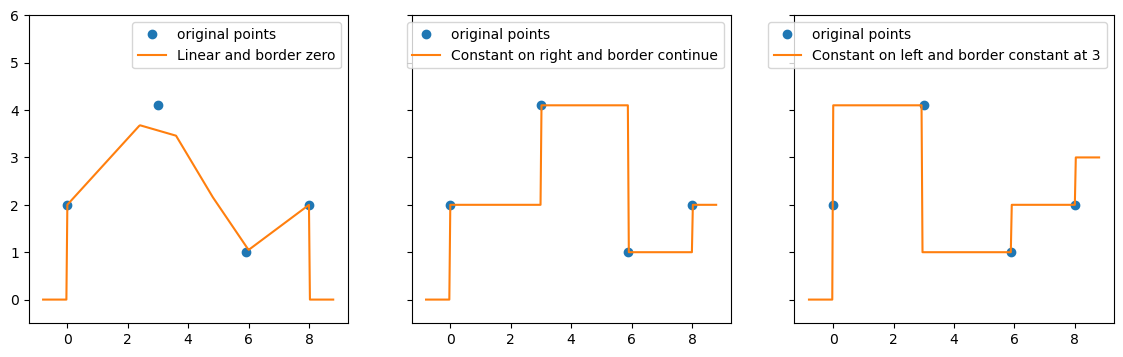

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from tick.base import TimeFunction
from tick.plot import plot_timefunction

T = np.array([0, 3, 5.9, 8.001], dtype=float)
Y = np.array([2, 4.1, 1, 2], dtype=float)

tf_1 = TimeFunction((T, Y), dt=1.2)
tf_2 = TimeFunction((T, Y), border_type=TimeFunction.BorderContinue,
                    inter_mode=TimeFunction.InterConstRight, dt=0.01)
tf_3 = TimeFunction((T, Y), border_type=TimeFunction.BorderConstant,
                    inter_mode=TimeFunction.InterConstLeft, border_value=3)

time_functions = [tf_1, tf_2, tf_3]

_, ax_list = plt.subplots(1, 3, figsize=(14, 4), sharey=True)

for tf, ax in zip(time_functions, ax_list):
    plot_timefunction(tf, ax=ax)
    ax.set_ylim([-0.5, 6.0])
plt.show()

## Simuation: Poisson Processes

### Simulation: Constant(homogenous) Intensity 

* Intensity function is a constant function. i.e if you take arbitrary large equal-sized time intervals, their  intensities are similar 

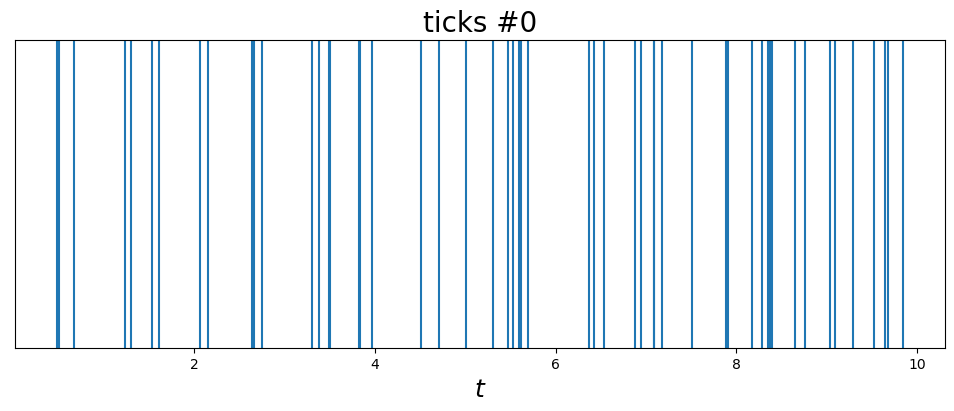

Number of total ticks (54,)


In [91]:
from tick.hawkes import SimuPoissonProcess
from tick.plot import plot_point_process

run_time = 10
intensity = 5 ## 5 times per time step 

poi = SimuPoissonProcess(intensity, end_time=run_time, verbose=False)
poi.simulate()
ticks_plt = plot_point_process(poi)
print("Number of total ticks", poi.timestamps[0].shape) ## Should be approximately run_time * intensity 

### Simulation: Inhomogenous Poissson  Process

**np.maximum** - compares two arrays elementwise and takes the maximum( so that the intensity is maximum )
    
    This makes the intesity value positive across time (clipping negative values as in the plot below)

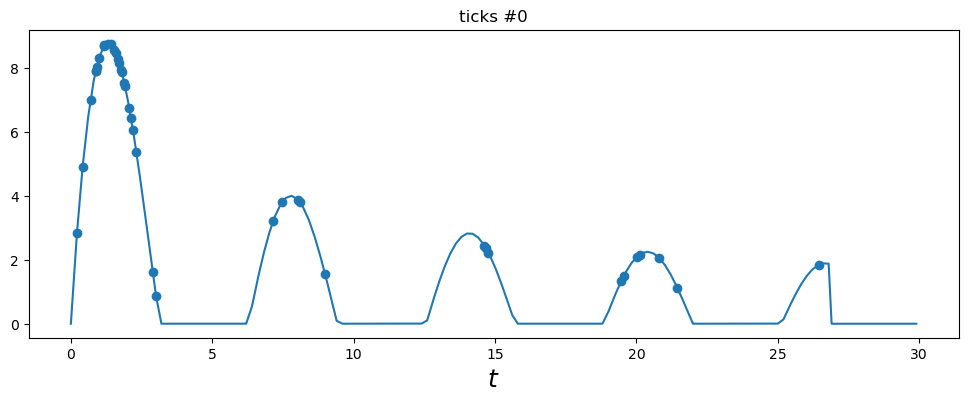

In [138]:
import numpy as np
from tick.base import TimeFunction

from tick.plot import plot_point_process
from tick.hawkes import SimuInhomogeneousPoisson

run_time = 30

T = np.arange((run_time * 0.9) * 5, dtype=float) / 5

## Shrinking sinosoidal curve
Y = np.maximum(
    15 * np.sin(T) * (np.divide(np.ones_like(T),
                                np.sqrt(T + 1) + 0.1 * T)), 0.001)

tf = TimeFunction((T, Y), dt=0.01)

# We define a 1 dimensional inhomogeneous Poisson process with the
# intensity function seen above
in_poi = SimuInhomogeneousPoisson([tf], end_time=run_time, verbose=False)

# We activate intensity tracking and launch simulation
in_poi.track_intensity(0.1)
in_poi.simulate()

# We plot the resulting inhomogeneous Poisson process with its
# intensity and its ticks over time
ticks_plt = plot_point_process(in_poi)

In [139]:
print("Simulated timestamps", in_poi.timestamps)

Simulated timestamps [array([ 0.21427894,  0.41340901,  0.70006475,  0.887923  ,  0.88958609,
        0.91711511,  0.99436108,  1.17441926,  1.18865927,  1.30797854,
        1.40717722,  1.53051851,  1.60262412,  1.66404193,  1.70331967,
        1.77985379,  1.8072956 ,  1.88348357,  1.90830573,  2.0591201 ,
        2.12308398,  2.19800777,  2.31252357,  2.89598325,  3.01340208,
        7.15689572,  7.48435614,  8.03115971,  8.09454577,  8.99045874,
       14.62415479, 14.68213983, 14.76555187, 19.46589016, 19.56032433,
       20.03138065, 20.12272452, 20.81258013, 21.45138927, 26.4604898 ])]


## Simulation: Hawkes Processes

### Single Dimension (D=1)

Exponetial kernels are defined as using two parameters 
* $\alpha_u$ - intensity of the kernal - how strong is the influence 
* $\beta_u$ - decay rate - how fast the influence dies 

$$
\phi(t) = \sum_{u=1}^{U} \alpha_u \beta_u \exp (- \beta_u t) 
1_{t > 0}
$$

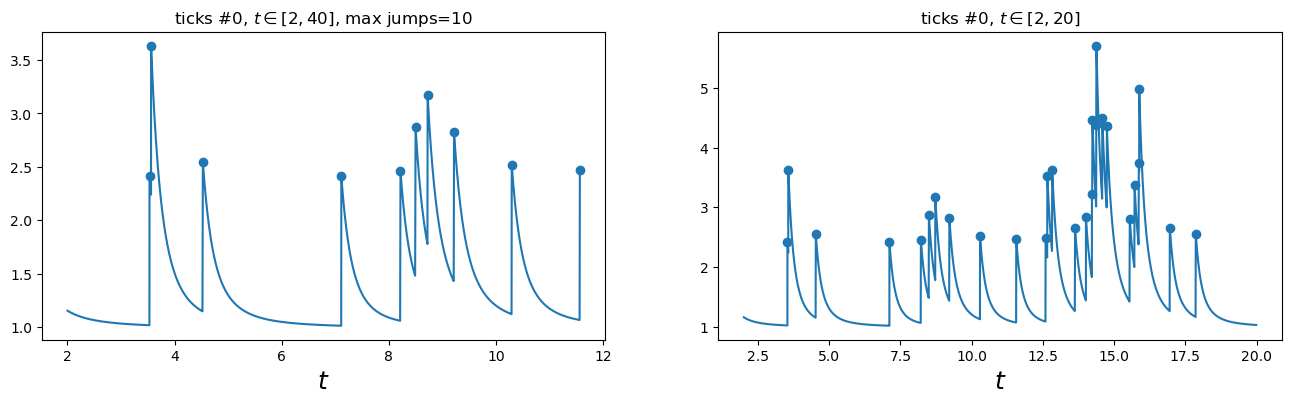

In [66]:

from tick.plot import plot_point_process
from tick.hawkes import SimuHawkes, HawkesKernelSumExp
import matplotlib.pyplot as plt

## The time frame 0-40 time steps  
run_time = 40


## Create a simulation of 1 node Hawkes Process 
hawkes = SimuHawkes(n_nodes=1, end_time=run_time, verbose=False, seed=1398)


## Create sum of exponentials 
## HawkesKernelSumExp(Intensities, Decays )
kernel = HawkesKernelSumExp([.1, .2, .1], [1., 3., 7.])
hawkes.set_kernel(0, 0, kernel)
hawkes.set_baseline(0, 1.)

dt = 0.01
hawkes.track_intensity(dt)
hawkes.simulate()
timestamps = hawkes.timestamps
intensity = hawkes.tracked_intensity
intensity_times = hawkes.intensity_tracked_times

_, ax = plt.subplots(1, 2, figsize=(16, 4))
plot_point_process(hawkes, n_points=50000, t_min=2, max_jumps=10, ax=ax[0])
plot_point_process(hawkes, n_points=50000, t_min=2, t_max=20, ax=ax[1])

### Multi Dimensional (D=4)


In this example, 

* **Process (0)** affects the other processes.
* **Process (0)** has zero(constant) intensity($\phi$) across the run time.  i.e. self/other influence on it is zero. 
* 

<ipython-input-133-244883970607>:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(n_nodes, 1, figsize=(16, 8), sharex=True, sharey=True)


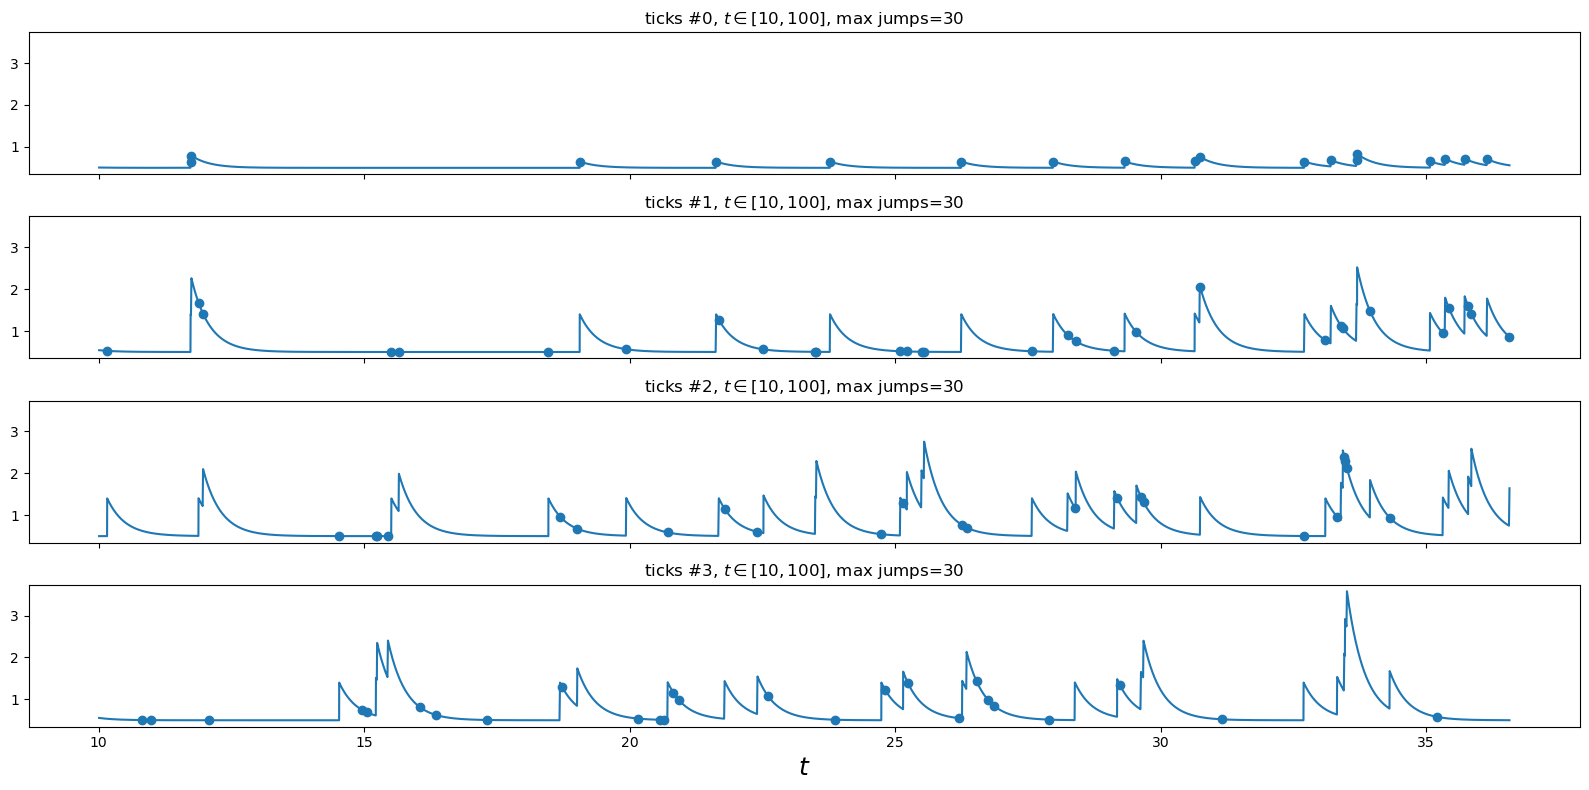

In [133]:
import numpy as np
import matplotlib.pyplot as plt

from tick.hawkes import SimuHawkesExpKernels
from tick.plot import plot_point_process

n_nodes = 4  # dimension of the Hawkes process
adjacency = np.zeros((n_nodes, n_nodes))
adjacency[0, 0] = .05

for i in range(1, 4): adjacency[i, i-1] = .3

decays = 3 * np.ones((n_nodes, n_nodes))
baseline = 0.5 * np.ones(n_nodes)
hawkes = SimuHawkesExpKernels(adjacency=adjacency, decays=decays,
                              baseline=baseline, verbose=False, seed=2398)

run_time = 100
hawkes.end_time = run_time
dt = 0.01
hawkes.track_intensity(dt)
hawkes.simulate()

fig, ax = plt.subplots(n_nodes, 1, figsize=(16, 8), sharex=True, sharey=True)
plot_point_process(hawkes, n_points=50000, t_min=10, max_jumps=30, ax=ax)
fig.tight_layout()
fig